## Prepare dataset

In [39]:
# !pip install lightgbm xgboost -q

In [40]:
import pandas as pd
import matplotlib.pyplot as plt 

dataset = pd.read_csv('./small-sample-BGU-30.csv', parse_dates=['reportts']) \
  .sort_values('reportts')

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [42]:
Y = dataset[['egtm']]
# , 'n1_delt', 'n2_delt'

X = dataset.drop(columns=[
    'reportts', 'acnum', 'pos', 'dep', 'arr', 
    'egtm', 'fltdes', 'reportts',
    'dmusw', 'exswpn', 'reason'
]).fillna(-100)

X = X.loc[:, ~X.columns.str.contains('stw')]

## Experiment with baselines

In [43]:
def get_score_by_parameter(predict_field, alg='catboost', X=X, Y=Y):
  y = Y[predict_field]

  x = X[y.notna()]

  y = y.dropna()
  
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
  
  # assert len(x) == len(y)
  # train_i = int(len(x) * 60 / 100)
  # X_train, y_train = x[0:train_i], y[0:train_i]
  # X_test, y_test = x[train_i:], y[train_i:]

  model = None
  if alg == 'linreg':
    model = LinearRegression(n_jobs=-1)
  elif alg == 'catboost':
    model = CatBoostRegressor(iterations=200, random_state=42, verbose=False)
  elif alg == 'lightgbm':
    model = LGBMRegressor(n_jobs=-1, random_state=42)
  elif alg == 'xgboost':
    model = XGBRegressor()
  elif alg == 'rand_forest':
    model = RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=42)
  
  scaler = StandardScaler()
  scaler.fit(X_train)

  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  preds = pd.DataFrame({'y': y_test, 'pred': predicted})
  mse = mean_squared_error(y_test, predicted, squared=False)
  mae = mean_absolute_error(y_test, predicted)
  
  return mse, mae, model, preds

In [44]:
scores = pd.DataFrame(columns=["model", "rmse", "mae"])
model_types = ["linreg", "rand_forest", "lightgbm", "catboost", "xgboost"]

models = {}
preds = {}
output_parameters = Y.columns

for model in model_types:
  mse, mae, result_model, pred = get_score_by_parameter('egtm', model)
  models[model] = result_model
  preds[model] = pred
  scores.loc[len(scores)] = [model, mse, mae]

scores

,model,rmse,mae
0,linreg,7.488699,1.871224
1,rand_forest,1.200956,0.705567
2,lightgbm,1.191570,0.752935
3,catboost,1.260287,0.851785
4,xgboost,1.109144,0.681612


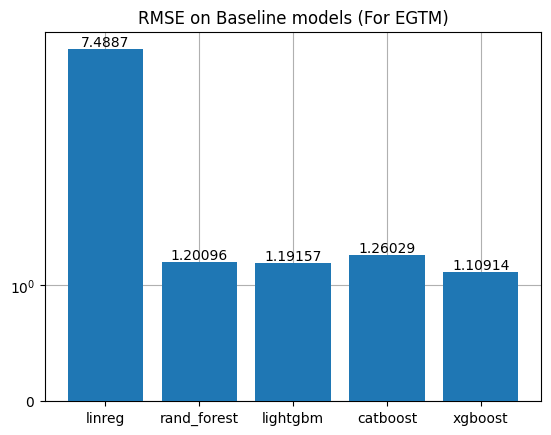

In [45]:
fig, ax = plt.subplots(1, 1)
ax.grid(zorder=0)
ax.set_yscale('symlog')
ax.bar(model_types, scores['rmse'], align='center', zorder=3)
ax.bar_label(ax.containers[0], label_type='edge')
ax.set_title('RMSE on Baseline models (For EGTM)')
plt.show()

In [46]:
preds['linreg']

,y,pred
771,26.687,28.104005
811,26.272,26.289654
263,26.000,27.883798
15,44.126,42.708949
818,25.568,26.187288
...,...,...
871,21.905,24.700624
848,22.301,22.672693
749,28.116,28.286804
624,33.974,33.355853


**TODO:**
1. Добавить линейную регрессию 
1. Разделить расчёт метрик по двигателям и фазам полёта
1. A321 - меньше допустимый запас egtm
1. В идеале EGTM +/- 2 градуса
1. Разделение по фазе полёта 
1. Построить корелляции каждого признака с таргетом
1. В дальнейшем использовать это для feature selection

## Feature importance

<Axes: title={'center': 'Catboost feature importance (top 30, log scale)'}, xlabel='param'>

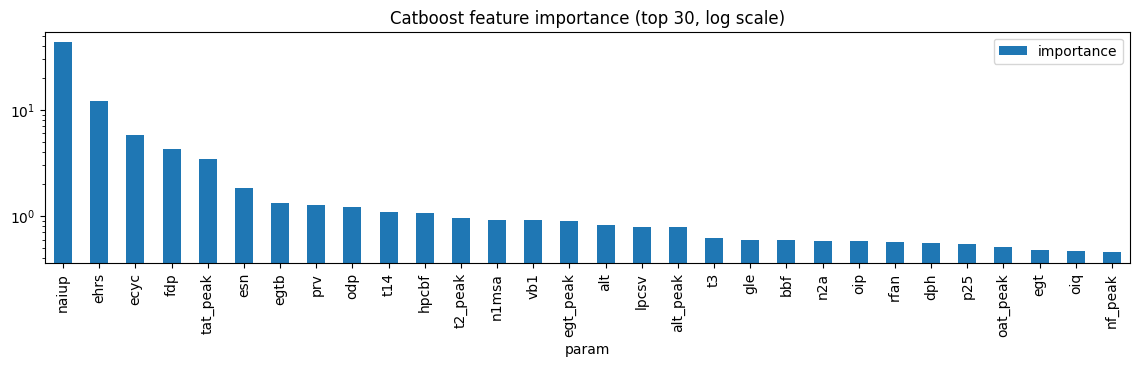

In [47]:
importance = pd.DataFrame({
    'importance': models['catboost'].feature_importances_, 
    'param': X.columns
}).sort_values(['importance', 'param'], ascending=False)    
    
importance.head(30) \
    .plot.bar(
        log=True,
        x='param',
        figsize=(14, 3),
        title="Catboost feature importance (top 30, log scale)"
    )

<Axes: title={'center': 'feature importance (top 30, log scale)'}, xlabel='param'>

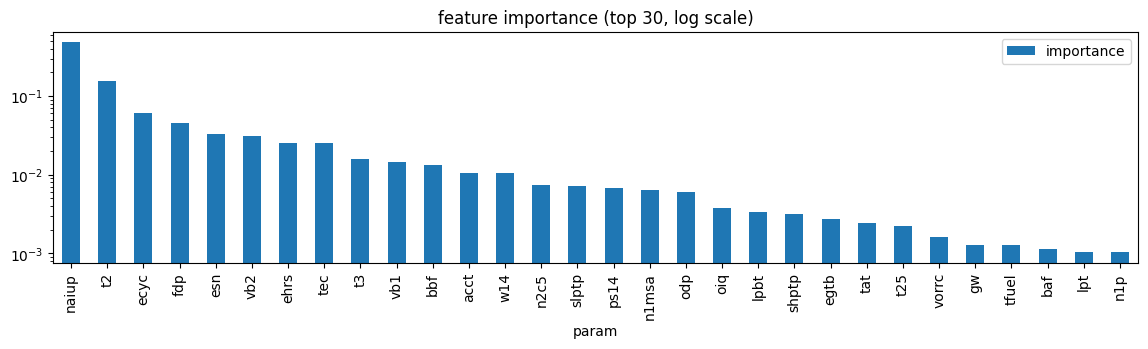

In [48]:
forest_importance = pd.DataFrame({
    'importance': models['xgboost'].feature_importances_, 
    'param': X.columns
}).sort_values(['importance', 'param'], ascending=False)    
    
forest_importance.head(30) \
    .plot.bar(
        log=True,
        x='param',
        figsize=(14, 3),
        title="feature importance (top 30, log scale)"
    )

**NOTE**: the most important features are `naiump, ehrs, ecsys, fdp`

In [49]:
scores_important = pd.DataFrame(columns=["model", "rmse", "mae"])
model_types = ["linreg", "rand_forest", "lightgbm", "catboost", "xgboost"]

models = {}
preds = {}
output_parameters = Y.columns

for model in model_types:
  mse, mae, result_model, pred = get_score_by_parameter(
    'egtm', model, X[importance[:10]['param']], Y
  )
  models[model] = result_model
  preds[model] = pred
  scores_important.loc[len(scores_important)] = [model, mse, mae]

scores_important

,model,rmse,mae
0,linreg,2.676003,2.160582
1,rand_forest,1.341563,0.607622
2,lightgbm,1.256245,0.739996
3,catboost,1.904837,0.823489
4,xgboost,3.348137,0.757840


#### Compare scores with all features and with important only

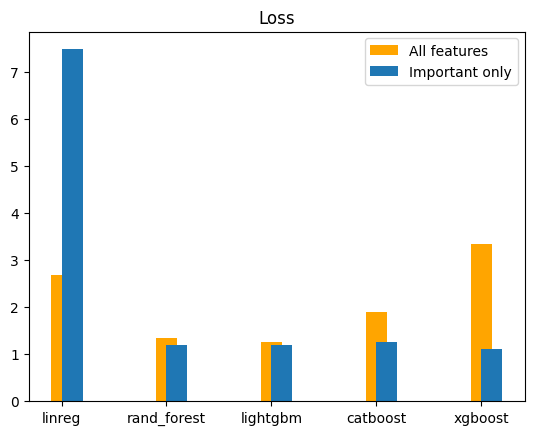

In [74]:
fig, ax = plt.subplots(1,1)

ax.bar(scores['model'], scores_important['rmse'], color='orange', align='center', width=0.2)
ax.bar(scores['model'], scores['rmse'], align='edge', width=0.2)
ax.legend(['All features', 'Important only'])
plt.title("Loss")
plt.show()